# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos 
manejables (aproximadamente unos 400MB a lo más), y hacer el preprocesamiento sobre cada subarchivo.
En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [1]:
push!(LOAD_PATH, ".")
using PreprocTools
using HDF5, PyPlot, Statistics

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/PreprocTools.ji for PreprocTools [top-level]
└ @ Base loading.jl:1190


La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [2]:
abrestring="/home/karel/BRWFiles/estriado/estriado_slice1_1004AP.brw"
stringgeneral=replace(abrestring, ".brw"=>"")  

"/home/karel/BRWFiles/estriado/estriado_slice1_1004AP"

In [3]:
a=h5open(abrestring);
names(a)

3-element Array{String,1}:
 "3BData"    
 "3BRecInfo" 
 "3BUserInfo"

In [4]:
names(a["3BUserInfo"])

2-element Array{String,1}:
 "ExpMarkers"
 "ExpNotes"  

In [5]:
bla=read(a["3BUserInfo"]["ExpNotes"])

1-element Array{HDF5.HDF5Compound{2},1}:
 HDF5.HDF5Compound{2}(("@\"7\x05", " (\xfa\x04"), ("Title", "Value"), (String, String))

In [222]:
bla[3]

2.01416015625

In [6]:
tamax=800*1024*1024  #maximo tamaño tolerable de archivo en una compu de 8GB de RAM (la de tu casa!!!)
tam=filesize(abrestring)
cachos=div(tam,tamax)+1

6

In [74]:
Datos=AbreyCheca(abrestring)

Dict{String,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "frecuencia"  => 17855.5
  "DatosCrudos" => UInt16[0x0000, 0x07f6, 0x080c, 0x07fe, 0x07f6, 0x07f6, 0x07f…
  "bitdepth"    => 0x0c
  "factor"      => 2.01416
  "numcuadros"  => 535665
  "duracion"    => 30.0

In [118]:
### parametetros globales.
freq=Datos["frecuencia"]/1000 #cuadros por milisegundo.
factor=Datos["factor"] #Factor de conversion de numeros enteros a microVolts
retrazo=round(Int, ceil(5*freq))
final=round(Int, ceil(60*freq))
latencia=round(Int, ceil(1.5*freq))


27

In [184]:
cuadrosmax=Datos["numcuadros"]
tiempototalms=round(cuadrosmax/freq; digits=1) 
println("Tienes ", cuadrosmax, " cuadros de muestreo a ", round(freq; digits=4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 535665 cuadros de muestreo a 17.8555 cuadros por milisegundo
Esto corresponde a  30000.0ms.


In [185]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.4227769342146373

In [219]:
Sys.free_memory()/(1024^3)

20.001995086669922

In [186]:
# Si los datos andan en un arreglo de lista en lugar de cuadrado, los ponemos cuadrados
if size(Datos["DatosCrudos"])[1] != 4096
DatosCrudosArreglados=reshape(Datos["DatosCrudos"], (4096, Datos["numcuadros"]))
else
DatosCrudosArreglados=Datos["DatosCrudos"]
end;

In [187]:
size(DatosCrudosArreglados)
DatosCrudosArreglados[70, 10:20]

11-element Array{UInt16,1}:
 0x07ff
 0x07f8
 0x0809
 0x0801
 0x0800
 0x07ef
 0x0803
 0x07f8
 0x0800
 0x0800
 0x0815

In [188]:
bla2(j,k)=64*(j-1)+k
bla2(33,48)


2096

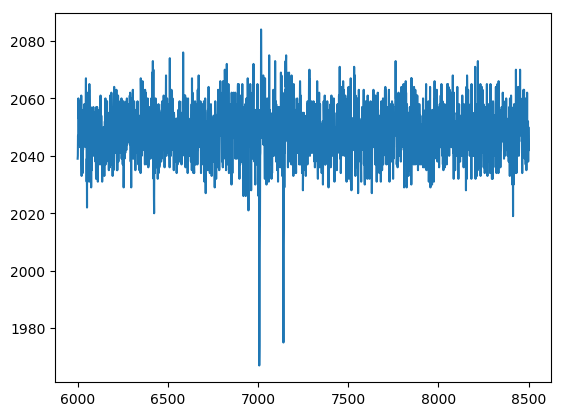

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fda4a048160>

In [189]:
rango=6000:8500
plot(rango, vec(DatosCrudosArreglados[2096,rango]))

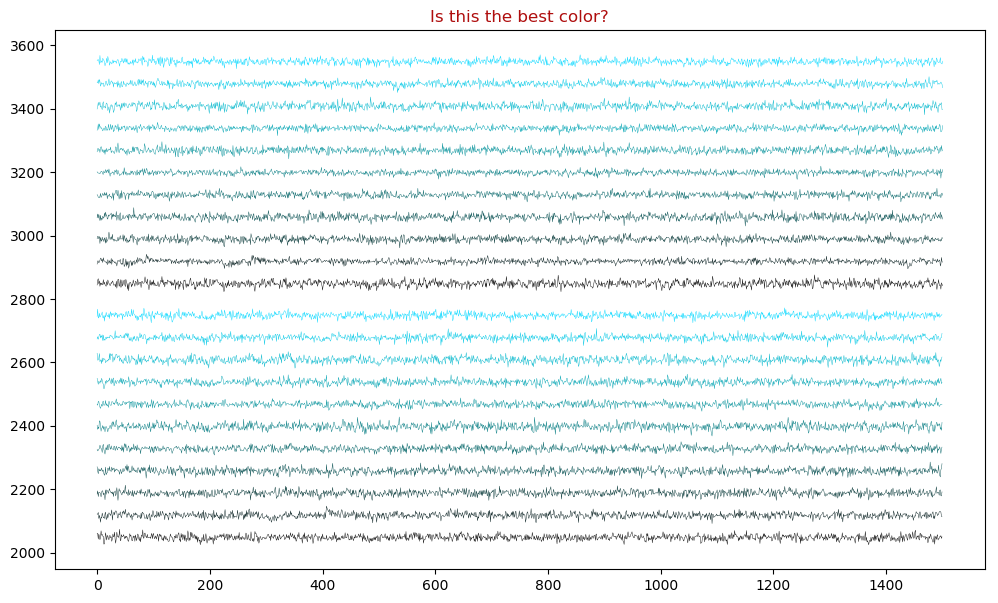

In [190]:
figure(figsize=(12,7))

title("Is this the best color?", color="#af0e0e")

jmax=10

for j=0:jmax
    k=j*64+3
    plot(DatosCrudosArreglados[k,1:1500].+70*j, lw=0.3, color=(0,sin(j/jmax),j/jmax))
end


for j=0:10
    k=j*64+3
    plot(DatosCrudosArreglados[k,52000:53500].+(800+70*j), lw=0.3, color=(0,sin(j/jmax),j/jmax))
end



In [191]:
DatosCrudosArreglados[1,100]==0

true

In [155]:
cachos

6

In [192]:
# si la fraccion de memoria libre es inferior a 0.2, tenemos que cortar un cacho de los datos. Que tan chico el cacho depende... 
# toca probar
if cachos > 1
    ## escoga el usuario un cacho para trabajar entre 1 y cachos
    cacho=6
    pedazo=round(Int, Datos["numcuadros"]/cachos)
    if cacho < cachos # si no es el ultimo cacho
        desde=1+(cacho-1)*pedazo
        hasta=cacho*pedazo
    else
        desde=1+(cacho-1)*pedazo
        hasta=cuadrosmax   
    end
    
    DatosCrudosArreglados=DatosCrudosArreglados[:,desde:hasta]
    palabritaespecial="/Cacho_$(cacho)_"
    
else
    palabritaespecial="/Completo_"
end

#    end;
# Liberar memoria
#Datos["DatosCrudos"]=0
println( "Este será el identificador del archivo en cachos: ", palabritaespecial)


Este será el identificador del archivo en cachos: /Cacho_6_


In [193]:
size(DatosCrudosArreglados), desde, hasta

((4096, 89275), 446391, 535665)

In [194]:
 DatosCentrados=FormaMatrizDatosCentrados(DatosCrudosArreglados, factor);
# libera memoria
#DatosCrudosArreglados=0

In [195]:
ncuadros=size(DatosCentrados)[3]

89275

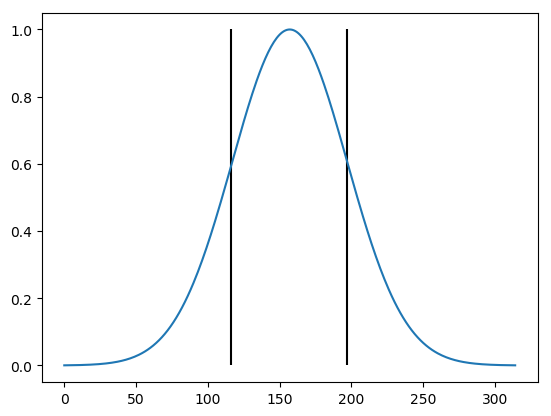

PyObject <matplotlib.collections.LineCollection object at 0x7fda75a86b38>

In [196]:
rango=1:21
fg=pesosgauss(40, 157)
bu=156-40
ba=157+40
plot(fg)
vlines([bu,ba], ymin=0,ymax=1)

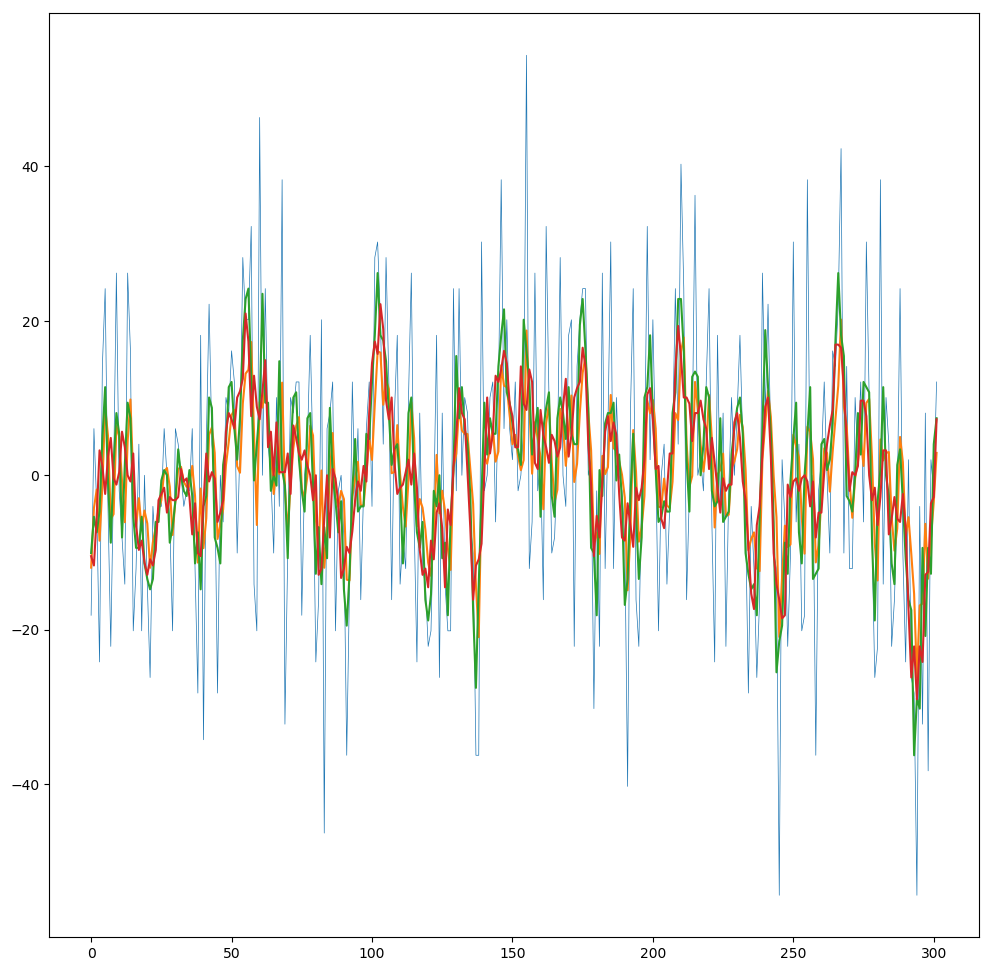

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fda75a610b8>

In [197]:
fig=figure(figsize=(12,12))
egtrazo=DatosCentrados[33,48,1100:1401];
egsg=suavegauss(egtrazo, 0.07);
egmav=mediamov(egtrazo,freq, 0.07)
egmav2=mediamov(egtrazo,freq, 0.1)
egmav3=mediamov(egtrazo,freq, 0.13)
plot(egtrazo, lw=0.5)
plot(egsg)
plot(egmav)
plot(egmav2)
#plot(egmav3)

In [198]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
#PruebaRespuesta=BCRP(DatosCentrados,freq, 0.1,100,-100, -300)
PruebaRespuesta=BuscaCanalRespActPot(DatosCentrados,freq, 0.1,100,-85, -300, 11, 24 )
#
# y luego los saturados
iniciobusqueda=0.1
finbusqueda=100
Saturados=BuscaSaturados(DatosCentrados,freq, 800,iniciobusqueda,finbusqueda)
OtrosSaturados=BuscaSaturadosStd(DatosCentrados, 0.1,100, freq, 26)
yOtrosMas=BuscaRuidosos(DatosCentrados, 0.1, 100, freq, 100, 3)
ns=size(Saturados)[1]
ns2=size(OtrosSaturados)[1]
ns3=size(yOtrosMas)[1]

nr=size(PruebaRespuesta)[1]
println("")
println("Encontramos ", ns, " canales probablemente saturados.")
println("Encontramos ", ns2, " canales probablemente con burbuja saturados.")
println("Encontramos ", ns3, " canales probablemente con ruido positivo.")
println("Encontramos ",  nr, " canales probablemente con actividad.")


Estoy buscando del cuadro 2 al , 1786

Encontramos 25 canales probablemente saturados.
Encontramos 180 canales probablemente con burbuja saturados.
Encontramos 136 canales probablemente con ruido positivo.
Encontramos 50 canales probablemente con actividad.


### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [199]:
DesviacionPorCanal=zeros(64,64)
PromPorCanal=zeros(64,64)
cini=round(Int, 0.1*freq)
cfin=round(Int, 100*freq)
for j=1:64
    for k=1:64
        ChorizoExemplo=vec(DatosCentrados[j,k,cini:cfin])
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
        PromPorCanal[j,k]=mean(ChorizoExemplo)
    end
end


In [200]:

ventmiliseg=100
ventanacuadros=round(Int,ventmiliseg*freq)
nventmax=size(DatosCentrados)[3]
nmax=div(nventmax,ventanacuadros)
sigmaventanas=zeros(64,64,nmax)

for j=1:64,k=1:64
    bla=vec(DatosCentrados[j,k,:])
    sigmaventanas[j,k,:]=desviacionventanas(bla, ventmiliseg)
end

In [201]:
extrema(sigmaventanas)
median(sigmaventanas)
median(sigmaventanas)

15.630419644521458

In [202]:
mean(PromPorCanal)
extrema(PromPorCanal)

(-4120.379279641544, 4122.98583984375)

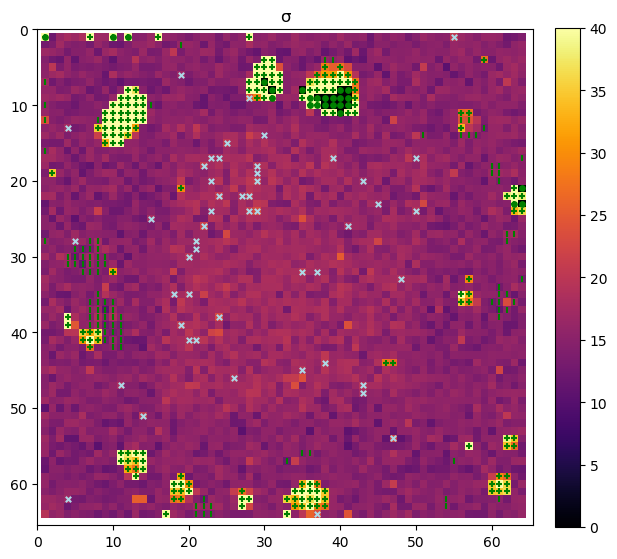

In [203]:
figure(figsize=(7,7))
xlim(0,65.5)
ylim(65.5,0)
title("σ")
limites=40
imagen=imshow(DesviacionPorCanal, origin="lower", interpolation="nearest",cmap="inferno", 
                      vmin=0,vmax=limites, extent=[0.5,64.5,0.5,64.5])
cb=colorbar(fraction=0.046, pad=0.04)

x=[]
y=[]
for j in 1:size(PruebaRespuesta)[1]
  append!(x,PruebaRespuesta[j,2])
   append!(y,PruebaRespuesta[j,1])
end


x2=[]
y2=[]
for j in 1:size(Saturados)[1]
  append!(x2,Saturados[j,2])
   append!(y2,Saturados[j,1])
end


x3=[]
y3=[]
for j in 1:size(OtrosSaturados)[1]
  append!(x3,OtrosSaturados[j,2])
   append!(y3,OtrosSaturados[j,1])
end



x4=[]
y4=[]
for j in 1:size(yOtrosMas)[1]
  append!(x4, yOtrosMas[j,2])
   append!(y4, yOtrosMas[j,1])
end




scatter(x,y, marker="x",c="lightblue", s=15)
scatter(x2,y2, marker="o",c="green", s=15)
scatter(x3,y3, marker="+",c="green", s=15)
scatter(x4,y4, marker="|",c="green", s=15)


savefig("Test.png", dpi=92)

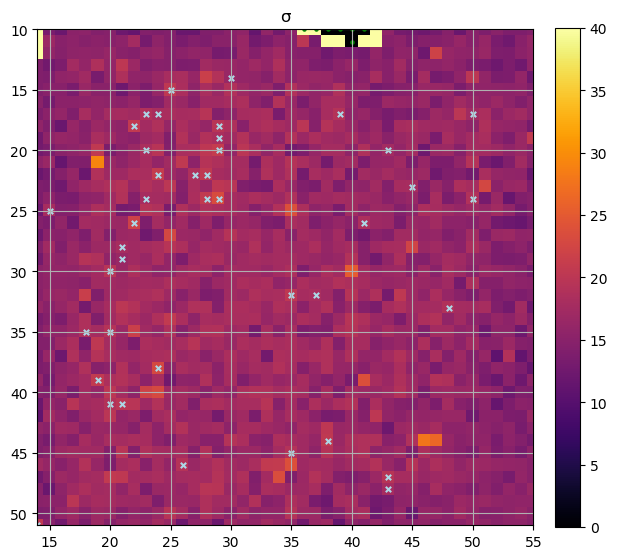

In [204]:
figure(figsize=(7,7))
xlim(14,55)
ylim(51,10)
title("σ")
limites=40
imagen=imshow(DesviacionPorCanal, origin="lower", interpolation="nearest",cmap="inferno", 
                      vmin=0,vmax=limites, extent=[0.5,64.5,0.5,64.5])
cb=colorbar(fraction=0.046, pad=0.04)

x=[]
y=[]
for j in 1:size(PruebaRespuesta)[1]
  append!(x,PruebaRespuesta[j,2])
   append!(y,PruebaRespuesta[j,1])
end


x2=[]
y2=[]
for j in 1:size(Saturados)[1]
  append!(x2,Saturados[j,2])
   append!(y2,Saturados[j,1])
end


scatter(x,y, marker="x",c="lightblue", s=15)
scatter(x2,y2, marker="o",c="green", s=5)
grid()

In [205]:
DesviacionPorCanal[46,35]

23.785123965946447

In [206]:
#=
ioff()
for n=1:nmax

 ioff()   
figure(figsize=(5,5))
xlim(0,65)
ylim(65,0)
title("σ ventana 100 ms")
limites=40
datos=sigmaventanas[:,:,n]
imagen=imshow(datos, origin="lower", interpolation="nearest",cmap="inferno", 
                      vmin=8,vmax=limites, extent=[0.5,64.5,0.5,64.5])
cb=colorbar(fraction=0.046, pad=0.04)

x=[]
y=[]
for j in 1:size(PruebaRespuesta)[1]
  append!(x,PruebaRespuesta[j,2])
   append!(y,PruebaRespuesta[j,1])
end


x2=[]
y2=[]
for j in 1:size(Saturados)[1]
  append!(x2,Saturados[j,2])
   append!(y2,Saturados[j,1])
end


scatter(x,y, marker="x",c="lightblue", s=10)
scatter(x2,y2, marker="o",c="green", s=3)
    
#outnmame="SigmaEstriado_Cacho_1_$n.png"    
#savefig(outnmame, dpi=90)    
    #close()
end
=#

Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [207]:
egtrazo=DatosCentrados[10,37,:];

In [208]:
egtrazo[29000:34000];

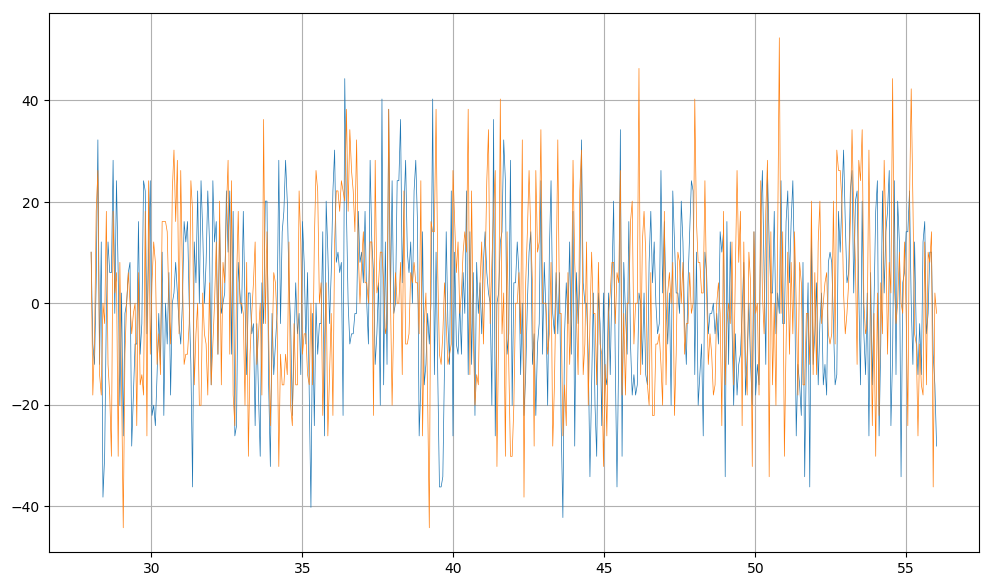

In [209]:
figure(figsize=(12,7))
rango=500:1000
rangot=rango./freq
plot(rangot, DatosCentrados[21,24,rango], lw=0.5)
plot(rangot, DatosCentrados[16,29,rango], lw=0.5)
grid()

In [210]:
std(DatosCentrados[13,13,1:1500])

30.874997488203086

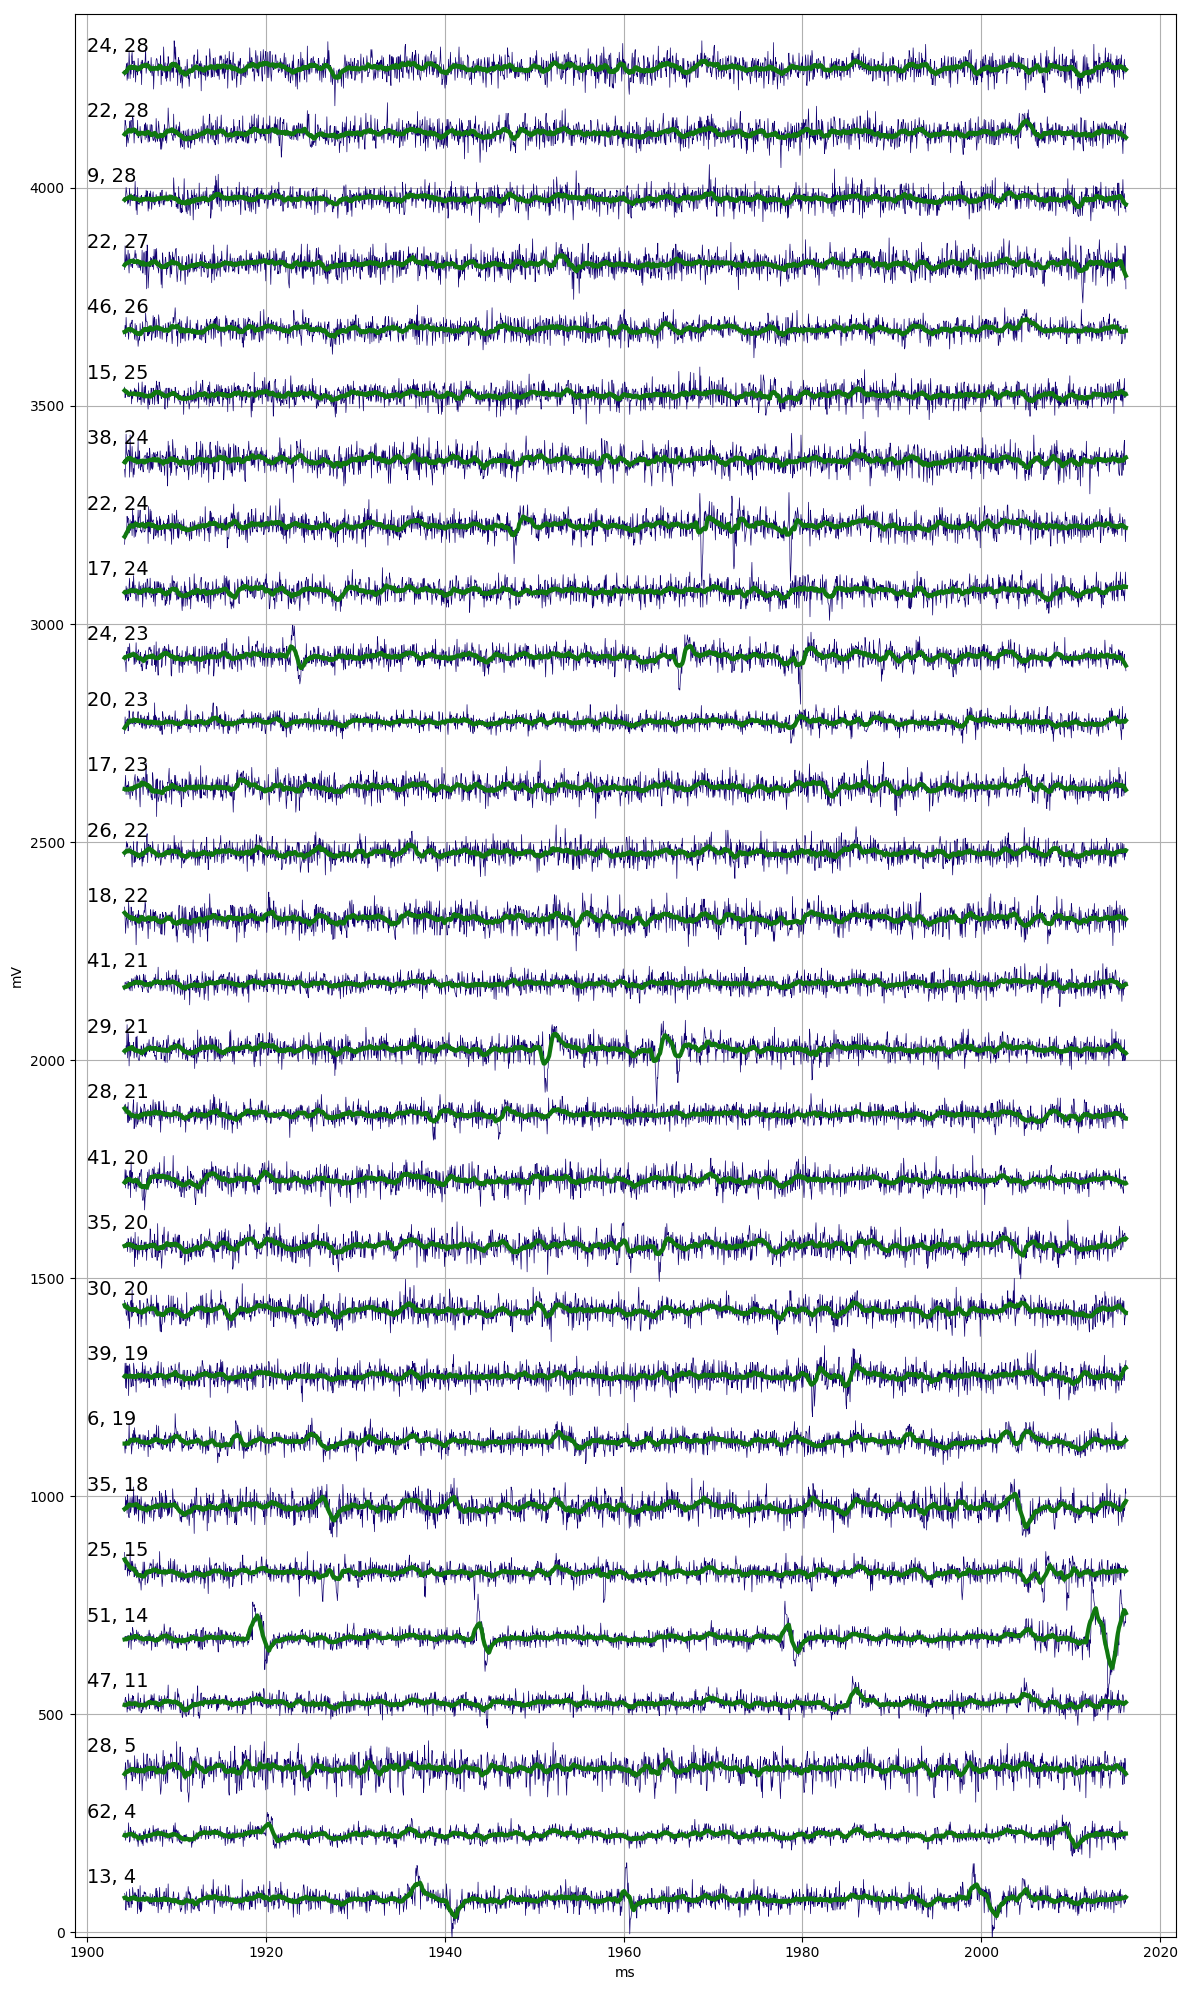

In [211]:
figure(figsize=(12,20))
xlabel("ms")
ylabel("mV")
ylim(-10,4400)

d1=34000
h1=36000
#intervalo=1:cacho
intervalo=d1:h1
intert=intervalo./(freq)


for j in 1:29
  l=PruebaRespuesta[j,1]
  k=PruebaRespuesta[j,2]
  egtrazo=DatosCentrados[l,k,intervalo].+(j-0.5)*150
  egtrazosuave=mediamov(egtrazo, freq, 0.5)
    annotate("$l, $k ", xy=(1900,(j-0.25)*150), fontsize=14)
    plot(intert,egtrazo, lw=0.5, c="#100070")
    plot(intert,egtrazosuave, lw=3, c="#107710")
end

bu=[1776,1796]
ba=[0,0]

bru=[1796,1796]
bra=[0,200]

#plot(bu,ba, lw=3, c="black")
#plot(bru,bra, lw=3, c="black")


#annotate("20ms", xy=(1780,20), fontsize=14)
#annotate("200mV", xy=(1797,140), fontsize=14, rotation=90)

#axis("off")
grid()

tight_layout()
#savefig("TrazosEjemploEstriado04.png", dpi=92)
#close()

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [212]:
dirname(stringgeneral), basename(stringgeneral)

("/home/karel/BRWFiles/estriado", "estriado_slice1_1004AP")

In [213]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
outname=string(dirgen,palabritaespecial, basegen, ".h5")
#aqui hay que arreglar el rollo del directorio

listaaguardar=Dict(
    "LFPSaturados" => DatosCentrados[:,:,desde:hasta],
     "desde" => desde,
    "hasta" => hasta,
     "freq" =>freq,
     "Canalesrespuesta" => PruebaRespuesta,
     "CanalesSaturados" => Saturados,
    "CanalesBurbuja"=>OtrosSaturados,
    "CanalesRuido"=>yOtrosMas)

println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

println("hemos guardado este cacho en el archivo ", outname)

/home/karel/BRWFiles/estriado/Cacho_6_estriado_slice1_1004AP.h5
abriendo los datos Canalesrespuesta
abriendo los datos CanalesBurbuja
abriendo los datos CanalesRuido
abriendo los datos desde
abriendo los datos hasta
abriendo los datos LFPSaturados
abriendo los datos freq
abriendo los datos CanalesSaturados
hemos guardado este cacho en el archivo /home/karel/BRWFiles/estriado/Cacho_6_estriado_slice1_1004AP.h5


In [214]:
typeof(listaaguardar)

Dict{String,Any}

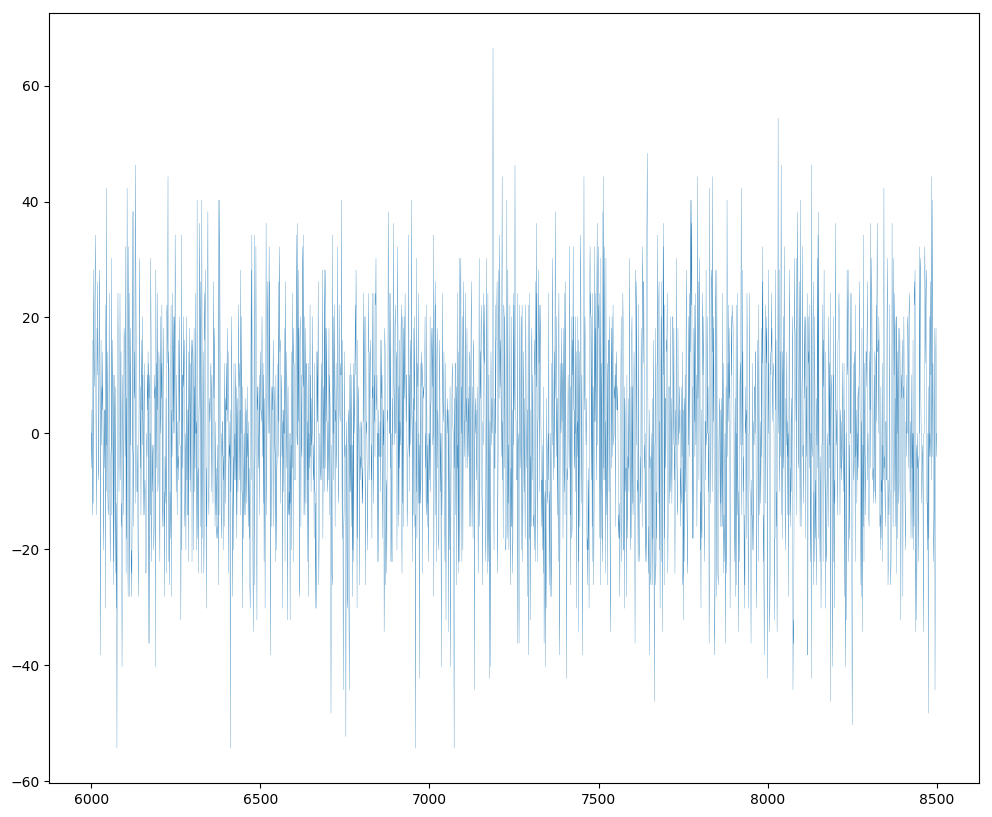

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fda4a0dad30>

In [215]:
figure(figsize=(12,10))


rango=6000:8500
trazoejemplo=DatosCentrados[33,48,rango]

plot(rango,trazoejemplo,lw=0.2)